# Homework Assignment


In [1]:
import awkward as ak
import hist as hist
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import uproot

## Problem 1

Continuing on with the workshop, the goal of this assignment is to plot the Z mass using the tools we've learned from the awkward library. Z decays into electron-positron or muon-antimuon.

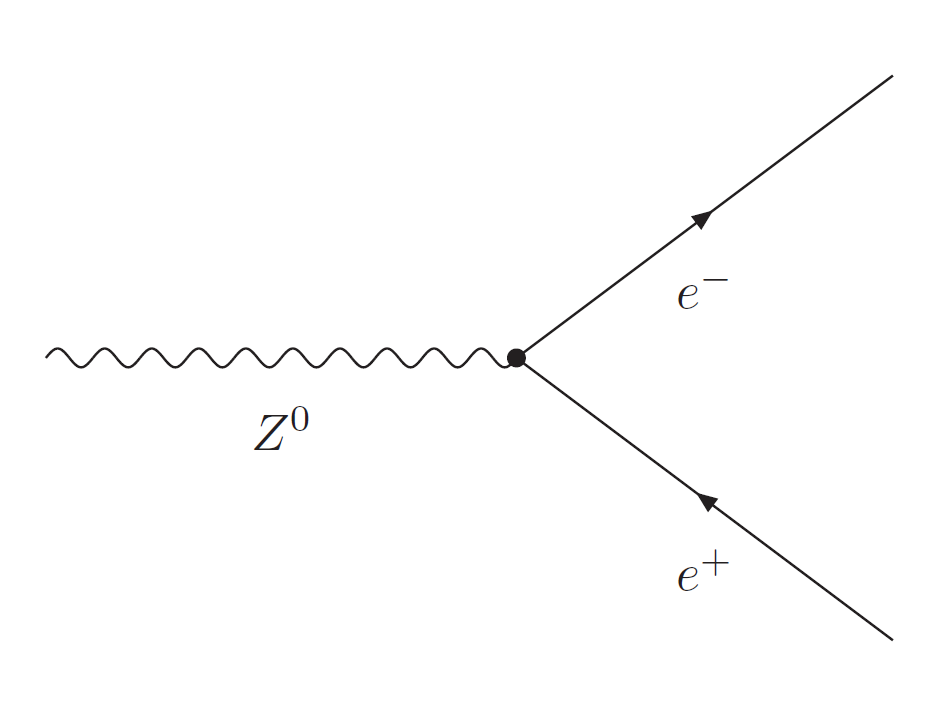
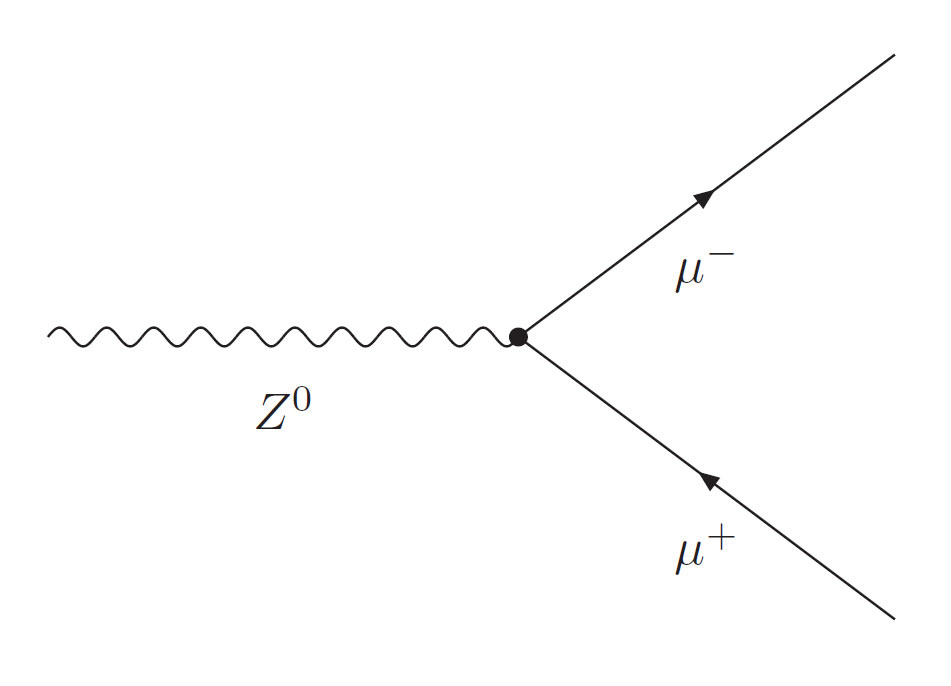

1. Create a function `selection_calc(lepton)` that applies the selection we've made above, obtains oppositely charged lepton pairs, and calculates the invariant mass. We want events with oppositely charged lepton pairs with pt > 25 GeV.
    
    **hint:** Re-use the functions already built in class.
    
    **note:** The data does not contain Muon mass, so you can assume all muons have mass = 0 (you might need to adjust the function `calc_invm` for this)

2. Plot the invariant mass of both electron and muon pairs on the same histogram. Find the peak of the histogram and return the Z mass.

### Data prep

In [2]:
# Open the ROOT file and access the tree
file = uproot.open("/lstr/sahara/act/data/DAOD_PHYSLITE.37621365._000015.pool.root.1")
tree = file["CollectionTree;1"]

# Get branches related to electrons and muons
Electrons = tree.arrays(["AnalysisElectronsAuxDyn.charge", 
                         "AnalysisElectronsAuxDyn.pt",
                         "AnalysisElectronsAuxDyn.eta",
                         "AnalysisElectronsAuxDyn.phi",
                         "AnalysisElectronsAuxDyn.m"])
Muons = tree.arrays(["AnalysisMuonsAuxDyn.charge",
                        "AnalysisMuonsAuxDyn.pt",
                        "AnalysisMuonsAuxDyn.eta",
                        "AnalysisMuonsAuxDyn.phi"])

# Pack electrons and muons into collections of records
e = ak.zip({
    "charge": Electrons["AnalysisElectronsAuxDyn.charge"],
    "pt": Electrons["AnalysisElectronsAuxDyn.pt"],
    "eta": Electrons["AnalysisElectronsAuxDyn.eta"],
    "phi": Electrons["AnalysisElectronsAuxDyn.phi"],
    "m": Electrons["AnalysisElectronsAuxDyn.m"]
})

mu = ak.zip({
    "charge": Muons["AnalysisMuonsAuxDyn.charge"],
    "pt": Muons["AnalysisMuonsAuxDyn.pt"],
    "eta": Muons["AnalysisMuonsAuxDyn.eta"],
    "phi": Muons["AnalysisMuonsAuxDyn.phi"]
})

### Functions from exercises

The invariant mass of two oppositely charged leptons is defined as:

$$\begin{align}
m_0 = \sqrt{(\sum E)^2 - (\sum p_x)^2 - (\sum p_y)^2 - (\sum p_z)^2}
\end{align}$$

In [3]:
# Functions for calculating transverse momentum and energy for a lepton
def Px(pt, phi):
    return pt * np.cos(phi)

def Py(pt, phi):
    return pt * np.sin(phi)

def Pz(pt, eta):
    return pt * np.sinh(eta)

def E(pt, eta, m=0):
    return np.sqrt(pt**2 * np.cosh(eta)**2 + m**2)

# Function for calculating invariant mass of two oppositely charged leptons
def calc_invm(p1, p2):
    sumpx = Px(p1.pt, p1.phi) + Px(p2.pt, p2.phi)
    sumpy = Py(p1.pt, p1.phi) + Py(p2.pt, p2.phi)
    sumpz = Pz(p1.pt, p1.eta) + Pz(p2.pt, p2.eta)

    # Check if p1, p2 have mass
    # If not, assume masses are 0
    # This only checks p1 -- assumes p2 has same fields
    sumE = 0
    if 'm' in p1.fields:
        sumE = E(p1.pt, p1.eta, p1.m) + E(p2.pt, p2.eta, p2.m)
    else:
        sumE = E(p1.pt, p1.eta) + E(p2.pt, p2.eta)
            
    invm = np.sqrt(sumE**2 - (sumpx**2 + sumpy**2 + sumpz**2))
    return invm

### `selection_calc`

In [4]:
def selection_calc(lepton):
    # Filter for events with at least two leptons with pt > 25 GeV
    clean_cut = (ak.num(lepton) >= 2) & (lepton.pt > 25_000)
    clean_lepton = lepton[clean_cut]
    
    # For each event, create all combinations of two leptons
    pairs = ak.combinations(clean_lepton, 2, axis=1, fields=['l1', 'l2'])

    # Find pairs with opposite charges
    # If charges are identical, we have -1 * -1 = 1 * 1 = 1
    # If charges are opposite, we have -1 * 1 = -1
    opposite_charge = ((pairs.l1.charge * pairs.l2.charge) < 0)
    pairs = pairs[opposite_charge]

    # Calculate invariant mass for each pair
    pairs['invm'] = calc_invm(pairs.l1, pairs.l2)

    # Return the pairs with their invariant mass
    return pairs

### Invariant masses of oppositely charged pairs

In [5]:
# Calculate invariant masses for electron pairs
e_pairs = selection_calc(e)

e_pair_indices = ak.where(ak.num(e_pairs) > 0)
e_pairs.invm[e_pair_indices]

<Array [[5.83e+05], [4.76e+05], ..., [1.38e+05]] type='104 * var * float32'>

In [6]:
# Calculate invariant masses for muon pairs
# Note that 
mu_pairs = selection_calc(mu)

mu_pair_indices = ak.where(ak.num(mu_pairs) > 0)
mu_pairs.invm[mu_pair_indices]

<Array [[7.88e+04], [9.2e+04], ..., [9.01e+04]] type='102434 * var * float32'>

### Invariant mass histogram

In [7]:
# Initial look at invariant mass distribution
flat_e_pairs = ak.flatten(e_pairs.invm)
flat_mu_pairs = ak.flatten(mu_pairs.invm)

flat_pairs = ak.flatten(ak.concatenate([e_pairs.invm, mu_pairs.invm]))

invm_hist = (
    hist.Hist.new
    .Regular(100, -1e3, 1e6, name="invm", label="Invariant Mass (GeV)")
    .Double()
    .fill(invm=flat_pairs)
)

invm_hist

Hist(Regular(100, -1000, 1e+06, name='invm', label='Invariant Mass (GeV)'), storage=Double()) # Sum: 106201.0 (106206.0 with flow)

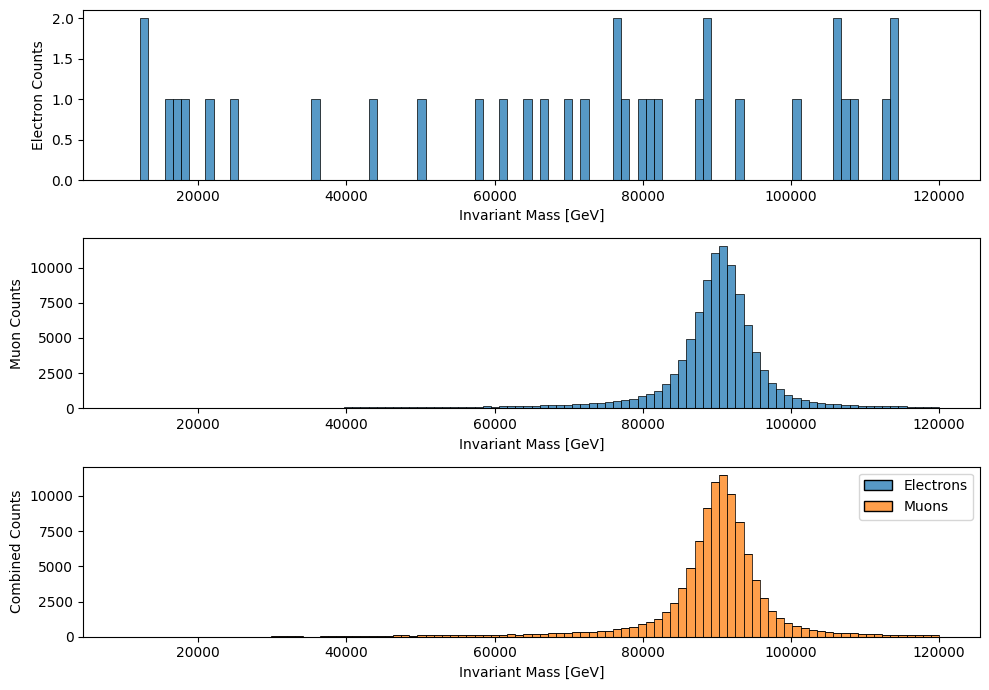

In [8]:
invm_min = 1e4
invm_max = 1.2e5

fig, ax = plt.subplots(3, 1, figsize=(10, 7))

# Plot electron invm histogram
sns.histplot(data=flat_e_pairs, bins=100, binrange=[invm_min, invm_max], ax=ax[0])
ax[0].set_xlabel("Invariant Mass [GeV]")
ax[0].set_ylabel("Electron Counts")

# Plot muon invm histogram
sns.histplot(data=flat_mu_pairs, bins=100, binrange=[invm_min, invm_max], ax=ax[1])
ax[1].set_xlabel("Invariant Mass [GeV]")
ax[1].set_ylabel("Muon Counts")

# Plot combined histogram
sns.histplot(data={"Electrons": flat_e_pairs, "Muons": flat_mu_pairs}, 
             bins=100, binrange=[invm_min, invm_max], ax=ax[2], multiple="stack")
ax[2].set_xlabel("Invariant Mass [GeV]")
ax[2].set_ylabel("Combined Counts")

plt.tight_layout()

### Z mass calculation

In [9]:
# Redefine histogram to be zoomed in on peak
invm_hist_zoomed = (
    hist.Hist.new
    .Regular(100, 8e4, 1.2e5, name="invm", label="Invariant Mass (GeV)")
    .Double()
    .fill(invm=flat_pairs)
)

# Extract peak of invariant mass distribution
invm_peak_index = np.argmax(invm_hist_zoomed.values())
invm_peak_bin = invm_hist_zoomed.axes.bin(invm_peak_index)[0]
est_Z_mass = (invm_peak_bin[0] + invm_peak_bin[1]) / 2
print(f"Estimated Z boson mass: {est_Z_mass:.2f} GeV")

Estimated Z boson mass: 90200.00 GeV


## Problem 2

Now you're on your own! We will make selections used for top quark mass calculation, using ATLAS ttbar mc sample, `/lstr/sahara/act/data/DAOD_PHYSLITE.37620644._000012.pool.root.1`.

1. Make a selection of events that have at least one lepton with pt > 30 GeV and abs(eta) < 2.1, and at least four jets. The jets should also have pt > 25 GeV and abs(eta) < 2.4. How many events were selected? Plot distribution plots to check selection.

2. Now let's check jet quality. The btag discriminant is defined as:

$$\begin{align}
D_{DL1} = \log(\frac{p_b}{f_c \cdot p_c + (1 - f_c) \cdot p_u})
\end{align}$$

where $p_b$, $p_c$, $p_u$ are the fields labeled `BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pb`, `BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pc`, `BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pu`, and $f_c = 0.018$. Calculate the Btag discriminant of the selected jets.

3. A jet is considered as b-tagged if the $D_{DL1}$ variable is above threshold. The threshold value for 77% efficiency is `2.456`. Make another selection of events that have at least two b-tagged jets. How many events were selected? Plot distribution plots to check selection.

**Hint:** `ak.any(...)` can help.

### Data prep

In [10]:
# Open the ROOT file and access the tree
file = uproot.open("/lstr/sahara/act/data/DAOD_PHYSLITE.37620644._000012.pool.root.1")
tree = file["CollectionTree;1"]

# Get branches related to leptons
Electrons = tree.arrays(["AnalysisElectronsAuxDyn.pt",
                         "AnalysisElectronsAuxDyn.eta"])

Muons = tree.arrays(["AnalysisMuonsAuxDyn.pt",
                     "AnalysisMuonsAuxDyn.eta"])

# Get branches related to jets
Jets = tree.arrays(["AnalysisJetsAuxDyn.pt",
                    "AnalysisJetsAuxDyn.eta"])

# Get branches related to btagging
Btag = tree.arrays(["BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pb",
                    "BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pc",
                    "BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pu"])

# Pack leptons and jets into collections of records
e = ak.zip({
    "pt": Electrons["AnalysisElectronsAuxDyn.pt"],
    "eta": Electrons["AnalysisElectronsAuxDyn.eta"]
})

mu = ak.zip({
    "pt": Muons["AnalysisMuonsAuxDyn.pt"],
    "eta": Muons["AnalysisMuonsAuxDyn.eta"]
})

j = ak.zip({
    "pt": Jets["AnalysisJetsAuxDyn.pt"],
    "eta": Jets["AnalysisJetsAuxDyn.eta"]
})

b = ak.zip({
    "pb": Btag["BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pb"],
    "pc": Btag["BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pc"],
    "pu": Btag["BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pu"]
})

### Event selection

In [11]:
# Quick sanity check of lengths
len(e), len(mu), len(j), len(b)

(160000, 160000, 160000, 160000)

In [12]:
# And of counts
ak.num(e), ak.num(mu), ak.num(j), ak.num(b)

(<Array [0, 0, 0, 0, 2, 1, 1, 0, ..., 1, 0, 0, 0, 0, 1, 0] type='160000 * int64'>,
 <Array [3, 1, 1, 1, 0, 0, 0, 0, ..., 2, 0, 1, 1, 1, 1, 2] type='160000 * int64'>,
 <Array [7, 7, 8, 9, 6, 12, 9, ..., 6, 10, 7, 5, 13, 13] type='160000 * int64'>,
 <Array [7, 7, 8, 9, 6, 12, 9, ..., 6, 10, 7, 5, 13, 13] type='160000 * int64'>)

In [13]:
def lepton_selection(e, mu):
    # Filter for at least 1 lepton with pt > 30 GeV and abs(eta) < 2.1
    e_cut = (e.pt > 30_000) & (abs(e.eta) < 2.1)
    mu_cut = (mu.pt > 30_000) & (abs(mu.eta) < 2.1)

    selected_e = ak.any(e_cut, axis=1)
    selected_mu = ak.any(mu_cut, axis=1)
    selected_lepton = (selected_e | selected_mu)

    return selected_lepton

def j_selection(j):
    # Filter for at least 4 jets with pt > 25 GeV and abs(eta) < 2.4
    j_cut = (j.pt > 25_000) & (abs(j.eta) < 2.4) & (ak.num(j) >= 4)
    selected_j = ak.any(j_cut, axis=1)
    return selected_j

def event_selection(e, mu, j):
    # Apply lepton and jet selection
    selected_lepton = lepton_selection(e, mu)
    selected_j = j_selection(j)

    # Combine selections
    return selected_lepton & selected_j

# Print indices of selected events
selected_events = event_selection(e, mu, j)
print("Events selected:", ak.sum(selected_events))

Events selected: 73776


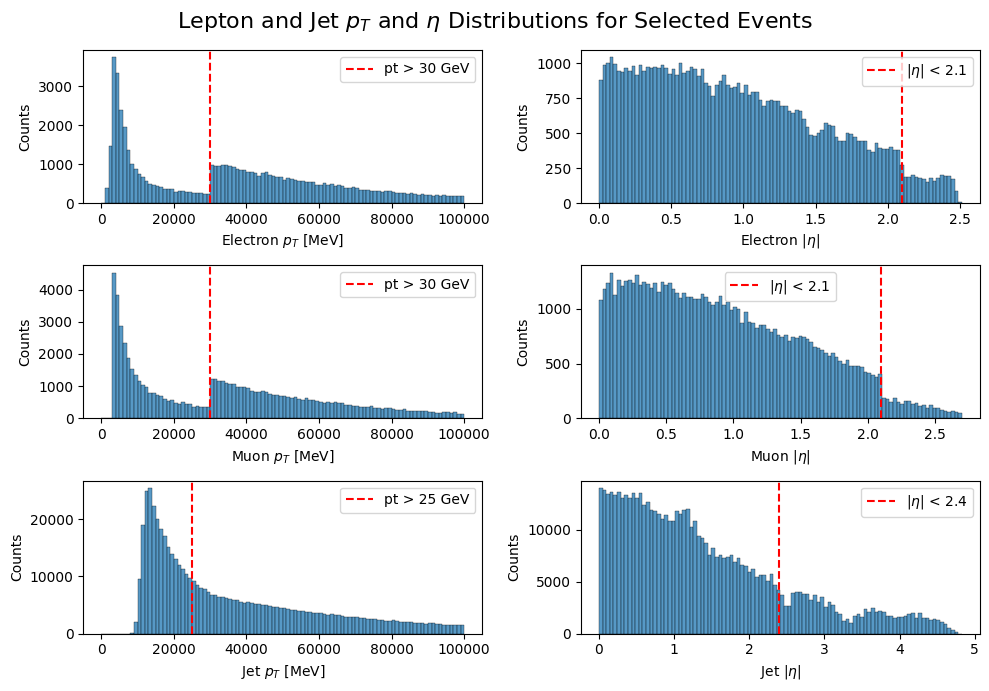

In [14]:
def plot_pt_eta_distributions(e, mu, j, selected_events):
    fig, ax = plt.subplots(3, 2, figsize=(10, 7))
    fig.suptitle(r"Lepton and Jet $p_T$ and $\eta$ Distributions for Selected Events", fontsize=16)

    pt_min = 0
    pt_max = 1e5

    # Plot electron pt distribution
    sns.histplot(data=ak.flatten(e[selected_events].pt), bins=100, binrange=[pt_min, pt_max], ax=ax[0, 0])
    ax[0, 0].axvline(x=30_000, color='r', linestyle='--', label='pt > 30 GeV')
    ax[0, 0].set_xlabel(r"Electron $p_T$ [MeV]")
    ax[0, 0].set_ylabel("Counts")
    ax[0, 0].legend()

    # Plot muon pt distribution
    sns.histplot(data=ak.flatten(mu[selected_events].pt), bins=100, binrange=[pt_min, pt_max], ax=ax[1, 0])
    ax[1, 0].axvline(x=30_000, color='r', linestyle='--', label='pt > 30 GeV')
    ax[1, 0].set_xlabel(r"Muon $p_T$ [MeV]")
    ax[1, 0].set_ylabel("Counts")
    ax[1, 0].legend()

    # Plot jet pt distribution
    sns.histplot(data=ak.flatten(j[selected_events].pt), bins=100, binrange=[pt_min, pt_max], ax=ax[2, 0])
    ax[2, 0].axvline(x=25_000, color='r', linestyle='--', label='pt > 25 GeV')
    ax[2, 0].set_xlabel(r"Jet $p_T$ [MeV]")
    ax[2, 0].set_ylabel("Counts")
    ax[2, 0].legend()

    # Plot electron abs(eta) distribution
    sns.histplot(data=ak.flatten(abs(e[selected_events].eta)), bins=100, ax=ax[0, 1])
    ax[0, 1].axvline(x=2.1, color='r', linestyle='--', label=r'|$\eta$| < 2.1')
    ax[0, 1].set_xlabel(r"Electron $|\eta|$")
    ax[0, 1].set_ylabel("Counts")
    ax[0, 1].legend()

    # Plot muon abs(eta) distribution
    sns.histplot(data=ak.flatten(abs(mu[selected_events].eta)), bins=100, ax=ax[1, 1])
    ax[1, 1].axvline(x=2.1, color='r', linestyle='--', label=r'|$\eta$| < 2.1')
    ax[1, 1].set_xlabel(r"Muon $|\eta|$")
    ax[1, 1].set_ylabel("Counts")
    ax[1, 1].legend()

    # Plot jet abs(eta) distribution
    sns.histplot(data=ak.flatten(abs(j[selected_events].eta)), bins=100, ax=ax[2, 1])
    ax[2, 1].axvline(x=2.4, color='r', linestyle='--', label=r'|$\eta$| < 2.4')
    ax[2, 1].set_xlabel(r"Jet $|\eta|$")
    ax[2, 1].set_ylabel("Counts")
    ax[2, 1].legend()

    plt.tight_layout()

plot_pt_eta_distributions(e, mu, j, selected_events)

### Calculating btag discriminant

In [15]:
fc = 0.018

def btag_discriminant(b):
    return np.log(
        b.pb / 
        (
            (fc * b.pc) + 
            (1 - fc) * b.pu
        )
    )

# Calculate b-tagging discriminant for selected events
b_discriminant = btag_discriminant(b)
b_discriminant

<Array [[9.28, -1.02, ..., -0.887, -0.783], ...] type='160000 * var * float32'>

### Select events with b-tagged jets

In [16]:
# Apply b-tagging selection
b_tagged = b_discriminant > 2.456
b_tagged

<Array [[True, False, ..., False, False], ...] type='160000 * var * bool'>

In [17]:
# Sum over innermost boolean values to get count of b-tagged jets
b_tagged_count = ak.sum(b_tagged, axis=-1)
b_tagged_count

<Array [2, 0, 1, 2, 3, 1, 0, 1, ..., 0, 2, 2, 1, 1, 2, 1] type='160000 * int64'>

In [18]:
b_tagged_selection = b_tagged_count >= 2
b_tagged_selection

<Array [True, False, False, True, ..., False, True, False] type='160000 * bool'>

In [19]:
# Apply b-tagging selection to events
selected_events = event_selection(e, mu, j) & b_tagged_selection
print("Events selected with b-tagging:", ak.sum(selected_events))

Events selected with b-tagging: 36459


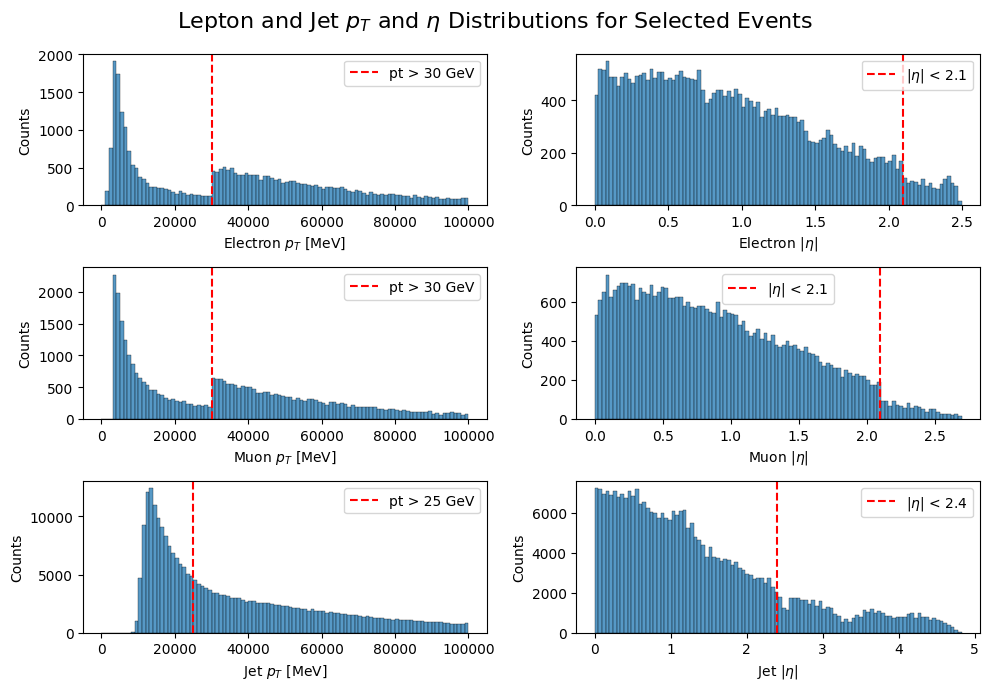

In [20]:
plot_pt_eta_distributions(e, mu, j, selected_events)

## Problem 3

Using the provided ttbar sample from CMS, `/lstr/sahara/act/data/TTto2L2Nu_NanoAODv12-130x_mcRun3_13p6TeV_powheg-pythia.root`, calculate the efficiency of the HLT_Mu8 trigger for events with 1 muon as a function of muon pT. At what muon pT does the trigger 'turn on'? Can you guess what the trigger name means? Do this again, but for events with 2 muons. Explain any similarities/differences as they relate to the trigger. You may use coffea or uproot as your entry point into the file.

**Note:** The efficiency of a trigger is defined as the ratio of the number of events passing the trigger (HLT_Mu8 = True) to all events. This is often done for individual bins of some quanity. Histogram objects from the Hist package can be divided.

### Data prep

In [21]:
# Open the ROOT file and access the tree
file = uproot.open("/lstr/sahara/act/data/TTto2L2Nu_NanoAODv12-130x_mcRun3_13p6TeV_powheg-pythia.root")
tree = file["Events;1"]

# Get branches related to muons
Muons = tree.arrays(["Muon_pt"])

# Get branches related to HLT
HLT = tree.arrays(['HLT_Mu8'])

# Pack muons and HLT into collections of records
mu = ak.zip({
    "pt": Muons["Muon_pt"]
})

hlt = ak.zip({
    "HLT_Mu8": HLT["HLT_Mu8"]
})

In [22]:
# Sanity check of lengths
len(mu), len(hlt)

(262125, 262125)

### 1 muon

In [23]:
# Select single muon events
single_mu = (ak.num(mu) == 1)
single_mu_pt = mu[single_mu].pt

# Make histogram
single_mu_hist = (
    hist.Hist.new
    .Regular(1000, -10, 100, name="Muon_pt", label="Muon pT [MeV]")
    .Double()
    .fill(Muon_pt=ak.flatten(single_mu_pt))
)

single_mu_hist

Hist(Regular(1000, -10, 100, name='Muon_pt', label='Muon pT [MeV]'), storage=Double()) # Sum: 95540.0 (101910.0 with flow)

In [24]:
# Select single muon events where HLT_Mu8 is on
hlt_on = (hlt.HLT_Mu8 == True)
single_mu_hlt = single_mu & hlt_on
single_mu_hlt_pt = mu[single_mu_hlt].pt

# Make histogram
single_mu_hlt_hist = (
    hist.Hist.new
    .Regular(1000, -10, 100, name="Muon_pt", label="Muon pT [MeV]")
    .Double()
    .fill(Muon_pt=ak.flatten(single_mu_hlt_pt))
)

single_mu_hlt_hist

Hist(Regular(1000, -10, 100, name='Muon_pt', label='Muon pT [MeV]'), storage=Double()) # Sum: 70218.0 (76132.0 with flow)

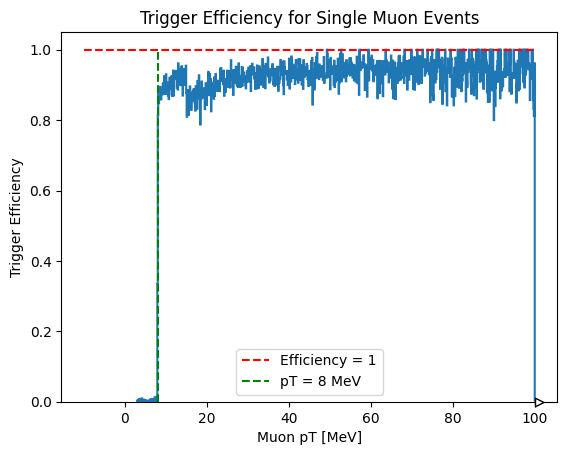

In [25]:
# Calculate trigger efficiency
trigger_efficiency = single_mu_hlt_hist / single_mu_hist

# Plot trigger efficiency
trigger_efficiency.plot1d()
plt.hlines(y=1.0, xmin=-10, xmax=100, color='r', linestyle='--', label='Efficiency = 1')
plt.vlines(x=8, ymin=0, ymax=1.0, color='g', linestyle='--', label='pT = 8 MeV')
plt.xlabel("Muon pT [MeV]")
plt.ylabel("Trigger Efficiency")
plt.title("Trigger Efficiency for Single Muon Events")
plt.legend()

### 2 muons

In [26]:
# Select double muon events
double_mu = (ak.num(mu) == 2)
double_mu_pt = mu[double_mu].pt

# Make histogram
double_mu_hist = (
    hist.Hist.new
    .Regular(1000, -10, 100, name="Muon_pt", label="Muon pT [MeV]")
    .Double()
    .fill(Muon_pt=ak.flatten(double_mu_pt))
)

double_mu_hist

Hist(Regular(1000, -10, 100, name='Muon_pt', label='Muon pT [MeV]'), storage=Double()) # Sum: 113876.0 (120798.0 with flow)

In [27]:
# Select double muon events where HLT_Mu8 is on
double_mu_hlt = double_mu & hlt_on
double_mu_hlt_pt = mu[double_mu_hlt].pt

# Make histogram
double_mu_hlt_hist = (
    hist.Hist.new
    .Regular(1000, -10, 100, name="Muon_pt", label="Muon pT [MeV]")
    .Double()
    .fill(Muon_pt=ak.flatten(double_mu_hlt_pt))
)

double_mu_hlt_hist

Hist(Regular(1000, -10, 100, name='Muon_pt', label='Muon pT [MeV]'), storage=Double()) # Sum: 102497.0 (109174.0 with flow)

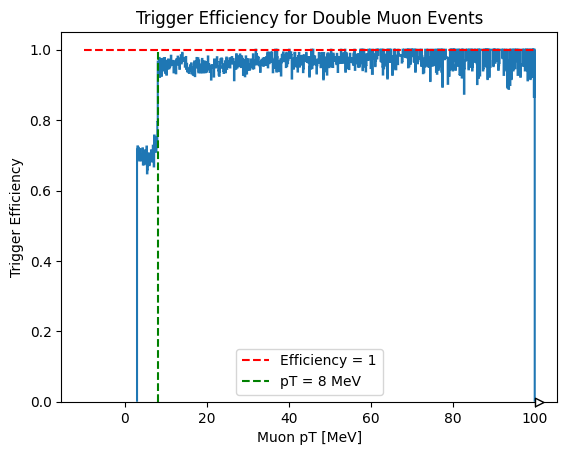

In [28]:
# Calculate trigger efficiency
trigger_efficiency_double = double_mu_hlt_hist / double_mu_hist

# Plot trigger efficiency
trigger_efficiency_double.plot1d()
plt.hlines(y=1.0, xmin=-10, xmax=100, color='r', linestyle='--', label='Efficiency = 1')
plt.vlines(x=8, ymin=0, ymax=1.0, color='g', linestyle='--', label='pT = 8 MeV')
plt.xlabel("Muon pT [MeV]")
plt.ylabel("Trigger Efficiency")
plt.title("Trigger Efficiency for Double Muon Events")
plt.legend()

### Discussion

- I'm guessing the `8` in `Mu8` means $8\,\,MeV$? (Or... $GeV$...? It was $MeV$ for the ATLAS data, I'm assuming it hasn't changed...)
- So the trigger is designed to catch muons at $p_T = 8\,\,MeV$ or higher
- In the case of a single muon, there's one giant leap up to near peak efficiency right at $8\,\,MeV$.
- In the case of two muons, there's an earlier step up to ~75% peak efficiency before $8\,\,MeV$, and I suspect... hmm...

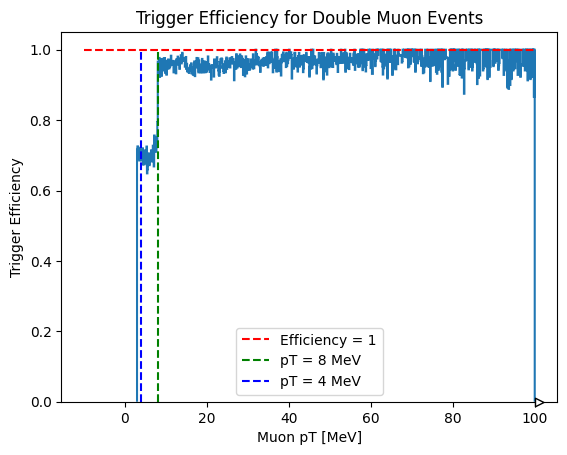

In [29]:
trigger_efficiency_double.plot1d()
plt.hlines(y=1.0, xmin=-10, xmax=100, color='r', linestyle='--', label='Efficiency = 1')
plt.vlines(x=8, ymin=0, ymax=1.0, color='g', linestyle='--', label='pT = 8 MeV')
plt.vlines(x=4, ymin=0, ymax=1.0, color='b', linestyle='--', label='pT = 4 MeV')
plt.xlabel("Muon pT [MeV]")
plt.ylabel("Trigger Efficiency")
plt.title("Trigger Efficiency for Double Muon Events")
plt.legend()

- Ok, so, yes, this is happening when you get muons with $p_T \approx 4\,\,MeV$, so at least one of the two muons together must be getting near $8\,\,MeV$.
- More specifically, it's not just that the combined muon $p_T$ is larger, its that the total muon $p_T$ is larger more often. Adding another muon totally changes the shape of the distribution of total muon $p_T$. It goes from having quite a few muons with $p_T < 8\,\,MeV$ to having very few below that threshold.... which I guess would be why the trigger uses that as a cut off point in the first place? Most single-muon events have $p_T > 8\,\,MeV$, and almost all double-muon events have $p_T \ge 8\,\,MeV$.

/home/abyrnes/.conda/envs/columnar_env/lib/python3.12/site-packages/mplhep/utils.py:577: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()


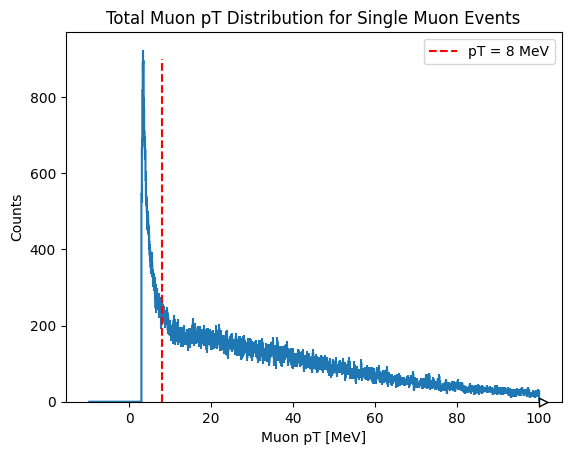

In [30]:
# Select single muon events
single_mu = (ak.num(mu) == 1)
single_mu_pt = mu[single_mu].pt

# Make histogram
single_mu_hist = (
    hist.Hist.new
    .Regular(1000, -10, 100, name="Muon_pt", label="Muon pT [MeV]")
    .Double()
    .fill(Muon_pt=ak.flatten(single_mu_pt))
)

# Plot normalized histogram
single_mu_hist.plot1d()
plt.vlines(x=8, ymin=0, ymax=900, color='r', linestyle='--', label='pT = 8 MeV')
plt.xlabel("Muon pT [MeV]")
plt.ylabel("Counts")
plt.title("Total Muon pT Distribution for Single Muon Events")
plt.legend()

/home/abyrnes/.conda/envs/columnar_env/lib/python3.12/site-packages/mplhep/utils.py:577: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()


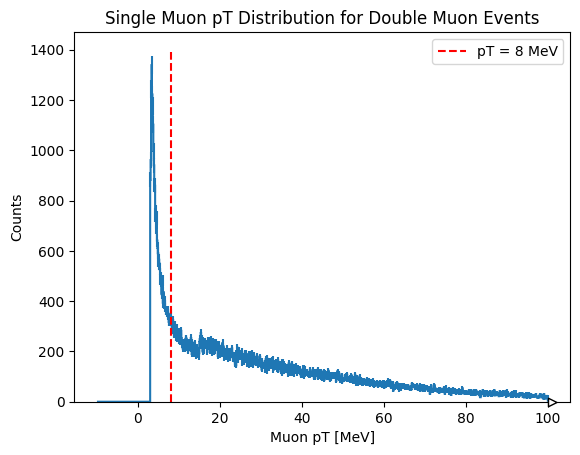

In [31]:
# Select double muon events
double_mu = (ak.num(mu) == 2)
double_mu_pt = mu[double_mu].pt

# Make histogram
double_mu_hist = (
    hist.Hist.new
    .Regular(1000, -10, 100, name="Muon_pt", label="Muon pT [MeV]")
    .Double()
    .fill(Muon_pt=ak.flatten(double_mu_pt))
)

double_mu_hist.plot1d()
plt.vlines(x=8, ymin=0, ymax=1400, color='r', linestyle='--', label='pT = 8 MeV')
plt.xlabel("Muon pT [MeV]")
plt.ylabel("Counts")
plt.title("Single Muon pT Distribution for Double Muon Events")
plt.legend()

/home/abyrnes/.conda/envs/columnar_env/lib/python3.12/site-packages/mplhep/utils.py:577: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()


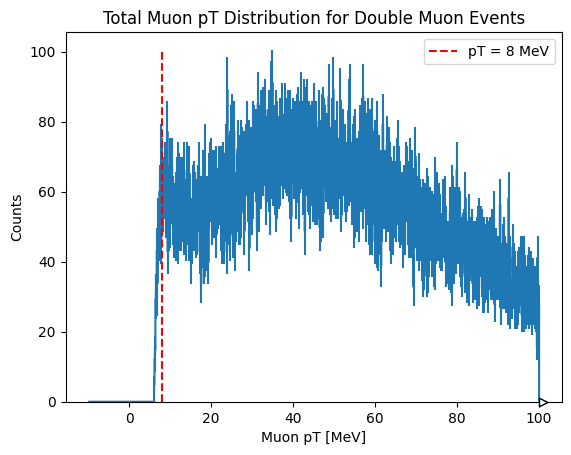

In [32]:
# Select double muon events
double_mu = (ak.num(mu) == 2)
double_mu_pt = ak.sum(mu[double_mu].pt, axis=-1)

# Make histogram
double_mu_hist = (
    hist.Hist.new
    .Regular(1000, -10, 100, name="Muon_pt", label="Muon pT [MeV]")
    .Double()
    .fill(Muon_pt=double_mu_pt)
)

double_mu_hist.plot1d()
plt.vlines(x=8, ymin=0, ymax=100, color='r', linestyle='--', label='pT = 8 MeV')
plt.xlabel("Muon pT [MeV]")
plt.ylabel("Counts")
plt.title("Total Muon pT Distribution for Double Muon Events")
plt.legend()